# Car value determination

A used cars sale service is developing an application in order to attract new customers. In this app you can quickly find out the market value of your car. 

The task is to build such a model based on the historical data: technical specifications, equipment and prices of cars. 

For customer is important:

- quality of the prediction;
- speed of the prediction;
- model learning time.

The metrics for the model selection is RMSE.

## Contents:
<a href='#first'>1) Data preprocessing and EDA </a> <br/>
<a href='#second'>2) Machine learning</a> <br/>
<a href='#third'>3) Model analysis</a> <br/>
<a href='#fourth'>4) Summary</a> <br/>

<a id='first'></a>
## 1. Data preprocessing and EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
import lightgbm as lgb

In [2]:
df_raw = pd.read_csv('/datasets/autos.csv')
df_raw.info()
display(df_raw.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


During the initial analysis of the data, **the following conclusions** can be drawn:

1) The dataset consists of 16 columns. The columns `DateCrawled`, `DateCreated`, `PostalCode`, `LastSeen` are proposed to be deleted, since they do not carry quality information for training the model, the `NumberOfPictures` column will be further analyzed. <br/>
2) Other columns are the learning features. A number of them have gaps: <br/>
2.1) The gaps in `NotRepaired` are proposed to be replaced with "No", because, probably, the field was omitted unintentionally. <br/>
2.2) Gaps in `VehicleType` are planned to be mapped to `Model` - if there is one body type per model, gaps can be filled based on this mapping. Otherwise, replace with `Other`. <br/>
2.3) Omissions of `Gearbox`, `Power` and `Model` can have a significant impact on the value of a car. At the same time, replacing gaps with the median or mean can distort the data. It is proposed to delete the data with these gaps. <br/>
2) The `Price` column is the target feature, has the correct data type and does not contain gaps. <br/>
3) Categorical features will be processed in the second step, depending on the model. For linear regression - OHE method. For gradient boosting, the Ordinal Encoder will be used.<br/>
4) Also, correlation and distribution graphs for the numerical characteristics will be plotted below for additional analysis.

In [3]:
print(df_raw['NumberOfPictures'].unique())
df_raw['NotRepaired'].unique()

[0]


array([nan, 'yes', 'no'], dtype=object)

<AxesSubplot:>

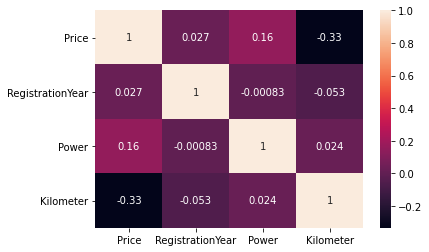

In [4]:
df = df_raw.drop(['DateCrawled','DateCreated','PostalCode','LastSeen','NumberOfPictures'],1)
int_columns = ['Price','RegistrationYear','Power','Kilometer']
df_corr = df[int_columns]
sns.heatmap(df_corr.corr(), annot=True)

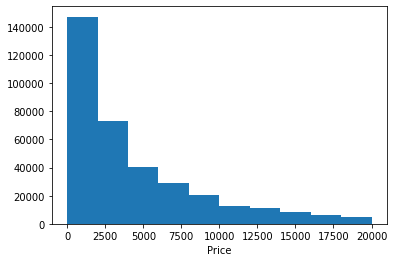

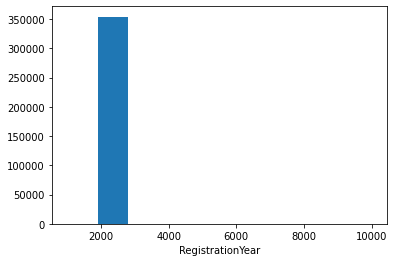

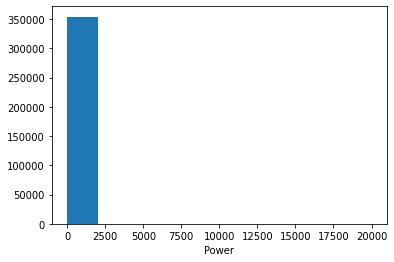

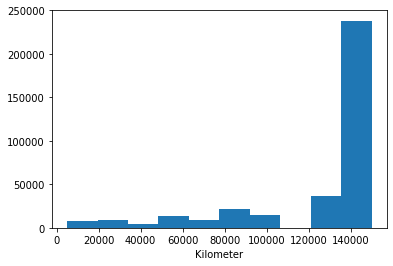

In [5]:
for column in int_columns:
    plt.hist(df[column])
    plt.xlabel(column)
    plt.show()
    print()

In [6]:
df.pivot_table(index=('Model','VehicleType'), values='Price', aggfunc='count').head(30)

Price
Model   VehicleType       
100     convertible      1
        coupe            2
        sedan          278
        wagon          109
145     coupe            2
        other            1
        sedan           13
        small           19
147     coupe           27
        other            7
        sedan          358
        small           97
        suv              1
        wagon            2
156     coupe            3
        other            1
        sedan          287
        small            2
        wagon          288
159     sedan           55
        wagon          145
1_reihe bus              5
        convertible      6
        coupe            3
        other            1
        sedan           30
        small         1090
        wagon           53
1er     convertible    251
        coupe          243

In [7]:
df['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

The following **intermediate conclusions** can be drawn:

5) The `NumberOfPictures` feature has been removed because all the answers are 0.<br/>
6) There is no multicolinearity of numerical features. <br/>
7) Features `Price`, `RegistrationYear`, `Power` contain a number of anomalies:<br/>
7.1) Car prices start at 0 and most of the data is centered around 0 to 2,000. The car is unlikely to be traded at level 0 - there may have been errors in the price, or the cars are put up for auction and the price tag is not final. It is proposed to get rid of anomalous price values, to leave cars **more expensive than zero**.<br/>
7.2) Car could not be registered before **~1970 and after 2022** - it is proposed to remove all the values, that do not fall within this range.<br/>
7.3) The power of the car varies from 80 to 100 hp. Accordingly, h.p. **above 1000 - probably erroneously multiplied by 10, above 10,000 - by 100**. It is proposed to correct these values. Also, after these transformations, it is proposed to delete values with the horse power **up to 50 h.p. and over 450 h.p.**<br/>
8) It is proposed to replace gaps in `VehicleType` with `other`, because one type of model corresponds to several types of types.

In [8]:
df = df.dropna(subset=['Gearbox','Model','FuelType'])

df = df[df['RegistrationYear']>1970]
df = df[df['RegistrationYear']<2023]

df['NotRepaired'] = df['NotRepaired'].fillna(value='no')
df['VehicleType'] = df['VehicleType'].fillna(value='other')

df['Power']= df['Power'].where(df['Power']<10000,df['Power']/100)
df['Power']= df['Power'].where(df['Power']<1000,df['Power']/10)
df.drop(df[df['Power'] < 50].index, inplace = True)
df.drop(df[df['Power'] > 450].index, inplace = True)

df.drop(df[df['Price'] == 0].index, inplace = True)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269378 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              269378 non-null  int64  
 1   VehicleType        269378 non-null  object 
 2   RegistrationYear   269378 non-null  int64  
 3   Gearbox            269378 non-null  object 
 4   Power              269378 non-null  float64
 5   Model              269378 non-null  object 
 6   Kilometer          269378 non-null  int64  
 7   RegistrationMonth  269378 non-null  int64  
 8   FuelType           269378 non-null  object 
 9   Brand              269378 non-null  object 
 10  NotRepaired        269378 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 24.7+ MB


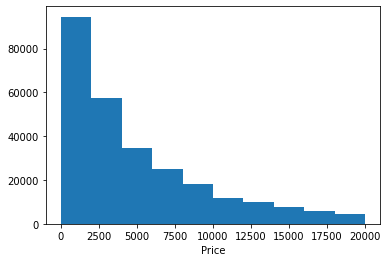

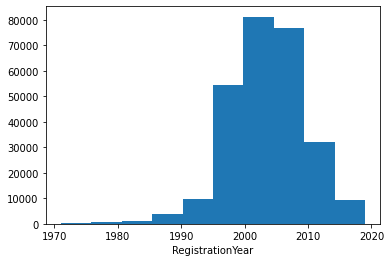

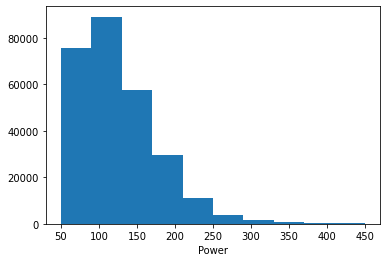

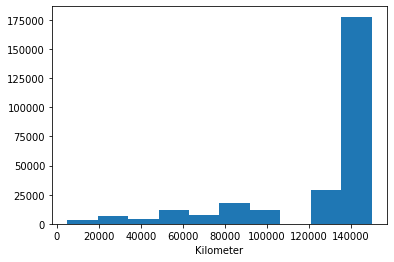

In [9]:
for column in int_columns:
    plt.hist(df[column])
    plt.xlabel(column)
    plt.show()
    print()

### Conclusion

Preprocessing and preparation of the data for further training of the models was carried out during the first step.

<a id='second'></a>
## 2. Machine learning

In [10]:
features = df.drop('Price',1)
target = df['Price']

binary_features = ['Gearbox', 'NotRepaired']
encoder = OrdinalEncoder()
features[binary_features] = encoder.fit_transform(features[binary_features])
features.info()

features=pd.get_dummies(features, drop_first=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269378 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VehicleType        269378 non-null  object 
 1   RegistrationYear   269378 non-null  int64  
 2   Gearbox            269378 non-null  float64
 3   Power              269378 non-null  float64
 4   Model              269378 non-null  object 
 5   Kilometer          269378 non-null  int64  
 6   RegistrationMonth  269378 non-null  int64  
 7   FuelType           269378 non-null  object 
 8   Brand              269378 non-null  object 
 9   NotRepaired        269378 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 22.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 269378 entries, 2 to 354368
Columns: 305 entries, RegistrationYear to Brand_volvo
dtypes: float64(3), int64(3), uint8(299)
memory usage: 91.2 MB


In [11]:
features_train_1, features_test, target_train_1, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)  
features_train, features_valid, target_train, target_valid = train_test_split(features_train_1, target_train_1, test_size=0.25, random_state=12345)

display(features_train.shape) 
display(features_test.shape) 
features_valid.shape 

(161626, 305)

(53876, 305)

(53876, 305)

In [12]:
def rmse_metrics(model):
    model_new = model
    model_new.fit(features_train, target_train)
    predicted_valid = model_new.predict(features_valid)
    mse=mean_squared_error(target_valid, predicted_valid, squared=False)
    return print('RMSE', mse)

In [13]:
%%time
rmse_metrics(LinearRegression())

RMSE 2459.019176757463
CPU times: user 9.86 s, sys: 6.7 s, total: 16.6 s
Wall time: 16.5 s


In [14]:
%%time
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)

CPU times: user 9.61 s, sys: 6.69 s, total: 16.3 s
Wall time: 16.3 s


LinearRegression()

In [15]:
%%time
predicted_valid = model_linear.predict(features_valid)

CPU times: user 77.1 ms, sys: 99.2 ms, total: 176 ms
Wall time: 189 ms


In [16]:
print("RMSE valid linear", mean_squared_error(target_valid, predicted_valid, squared=False))
print("RMSE test linear", mean_squared_error(target_test, model_linear.predict(features_test), squared=False))

RMSE valid linear 2459.019176757463
RMSE test linear 2466.837559508089


In [17]:
features = df.drop('Price',1)
target = df['Price']
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269378 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VehicleType        269378 non-null  object 
 1   RegistrationYear   269378 non-null  int64  
 2   Gearbox            269378 non-null  object 
 3   Power              269378 non-null  float64
 4   Model              269378 non-null  object 
 5   Kilometer          269378 non-null  int64  
 6   RegistrationMonth  269378 non-null  int64  
 7   FuelType           269378 non-null  object 
 8   Brand              269378 non-null  object 
 9   NotRepaired        269378 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 22.6+ MB


In [18]:
features_train_1, features_test, target_train_1, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)  
features_train, features_valid, target_train, target_valid = train_test_split(features_train_1, target_train_1, test_size=0.25, random_state=12345)

display(features_train.shape) 
display(features_test.shape) 
features_valid.shape 

(161626, 10)

(53876, 10)

(53876, 10)

In [19]:
%%time
model_cat = CatBoostRegressor(loss_function='RMSE', iterations=100, verbose=10)
cat_features = ['VehicleType', 'Gearbox', 'Model',
                'FuelType', 'Brand', 'NotRepaired']
model_cat.fit(features_train, target_train, cat_features=cat_features)

Learning rate set to 0.5
0:	learn: 3272.5958546	total: 142ms	remaining: 14s
10:	learn: 1894.6757407	total: 915ms	remaining: 7.4s
20:	learn: 1800.8869346	total: 1.44s	remaining: 5.42s
30:	learn: 1730.0650238	total: 2s	remaining: 4.46s
40:	learn: 1695.7607795	total: 2.47s	remaining: 3.56s
50:	learn: 1670.3940628	total: 2.93s	remaining: 2.82s
60:	learn: 1651.7051081	total: 3.37s	remaining: 2.15s
70:	learn: 1639.6181566	total: 3.81s	remaining: 1.56s
80:	learn: 1624.6314883	total: 4.25s	remaining: 998ms
90:	learn: 1613.0684885	total: 4.7s	remaining: 465ms
99:	learn: 1603.9021430	total: 5.1s	remaining: 0us
CPU times: user 5.33 s, sys: 262 µs, total: 5.33 s
Wall time: 6.29 s


In [20]:
%%time
predicted_valid = model_cat.predict(features_valid) 

CPU times: user 69.4 ms, sys: 0 ns, total: 69.4 ms
Wall time: 67.1 ms


In [21]:
print("RMSE valid cat", mean_squared_error(target_valid, predicted_valid, squared=False))
print("RMSE test cat", mean_squared_error(target_test, model_cat.predict(features_test), squared=False))

RMSE valid cat 1634.2243355237042
RMSE test cat 1660.461300097819


In [22]:
encoder = OrdinalEncoder()
features[cat_features] = encoder.fit_transform(features[cat_features])
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269378 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VehicleType        269378 non-null  float64
 1   RegistrationYear   269378 non-null  int64  
 2   Gearbox            269378 non-null  float64
 3   Power              269378 non-null  float64
 4   Model              269378 non-null  float64
 5   Kilometer          269378 non-null  int64  
 6   RegistrationMonth  269378 non-null  int64  
 7   FuelType           269378 non-null  float64
 8   Brand              269378 non-null  float64
 9   NotRepaired        269378 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 22.6 MB


In [23]:
features_train_1, features_test, target_train_1, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)  
features_train, features_valid, target_train, target_valid = train_test_split(features_train_1, target_train_1, test_size=0.25, random_state=12345)

display(features_train.shape) 
display(features_test.shape) 
features_valid.shape 

(161626, 10)

(53876, 10)

(53876, 10)

In [24]:
%%time
model_tree = DecisionTreeRegressor(max_depth=7)
model_tree.fit(features_train, target_train)

CPU times: user 238 ms, sys: 0 ns, total: 238 ms
Wall time: 247 ms


DecisionTreeRegressor(max_depth=7)

In [25]:
%%time
predicted_valid = model_tree.predict(features_valid)

CPU times: user 7.56 ms, sys: 0 ns, total: 7.56 ms
Wall time: 6.01 ms


In [26]:
print("RMSE valid tree", mean_squared_error(target_valid, predicted_valid, squared=False))
print("RMSE test tree", mean_squared_error(target_test, model_tree.predict(features_test) , squared=False))

RMSE valid tree 2163.200771969429
RMSE test tree 2192.8174416122765


In [27]:
%%time
model_forest = RandomForestRegressor(max_depth=7, n_estimators=70)
model_forest.fit(features_train, target_train)

CPU times: user 14.4 s, sys: 0 ns, total: 14.4 s
Wall time: 14.7 s


RandomForestRegressor(max_depth=7, n_estimators=70)

In [28]:
%%time
predicted_valid = model_forest.predict(features_valid) 

CPU times: user 240 ms, sys: 0 ns, total: 240 ms
Wall time: 250 ms


In [29]:
print("RMSE valid forest", mean_squared_error(target_valid, predicted_valid, squared=False))
print("RMSE test forest", mean_squared_error(target_test, model_forest.predict(features_test), squared=False))

RMSE valid forest 2084.6812183908896
RMSE test forest 2112.496393178594


In [30]:
%%time
model_lgbm1 = lgb.LGBMRegressor(max_depth=7, num_leaves=100, random_state = 12345)
model_lgbm1.fit(features_train, target_train)

CPU times: user 3min 7s, sys: 567 ms, total: 3min 8s
Wall time: 3min 10s


LGBMRegressor(max_depth=7, num_leaves=100, random_state=12345)

In [31]:
%%time
predicted_valid = model_lgbm1.predict(features_valid) 

CPU times: user 494 ms, sys: 0 ns, total: 494 ms
Wall time: 506 ms


In [32]:
print("RMSE valid lgbm1", mean_squared_error(target_valid, predicted_valid, squared=False))
print("RMSE test lgbm1", mean_squared_error(target_test, model_lgbm1.predict(features_test), squared=False))

RMSE valid lgbm1 1617.6135576922236
RMSE test lgbm1 1637.4187918093992


In [33]:
%%time
model_lgbm2 = lgb.LGBMRegressor(learning_rate = 0.7, max_depth=10, random_state = 12345)
model_lgbm2.fit(features_train, target_train)

CPU times: user 2min 8s, sys: 616 ms, total: 2min 9s
Wall time: 2min 10s


LGBMRegressor(learning_rate=0.7, max_depth=10, random_state=12345)

In [34]:
%%time
predicted_valid = model_lgbm2.predict(features_valid) 

CPU times: user 303 ms, sys: 0 ns, total: 303 ms
Wall time: 315 ms


In [35]:
print("RMSE valid lgbm1", mean_squared_error(target_valid, predicted_valid, squared=False))
print("RMSE test lgbm1", mean_squared_error(target_test, model_lgbm2.predict(features_test), squared=False))

RMSE valid lgbm1 1614.996549326201
RMSE test lgbm1 1624.4857327060479


### Conclusion
A number of models were trained in the second step. In addition, to the classic linear regression, decision tree and random forest models, gradient boosting models from the LGBM library and CatBooster were also applied. For different models, a different approach to processing categorical variables was used - OHE for **linear regression** and Ordinal Encoder for **the rest (except CatBooster).** CatBooster processes categorical variables independently.

<a id='third'></a>
## 3. Model analysis

| Model | RMSE | Learning time, seconds | Prediction time, seconds | 
| --- | --- | --- | --- |
| LGBm Regressor () | 1,625 | 130 | 0.3 | 
| LGBm Regressor () | 1,637 | 190 | 0.5 | 
| CatBoost Regression | 1,660 | 6 | 0.1 | 
| Random Forest | 2,112 | 15 | 0.3 | 
| Decision Tree | 2,193 | 0.3 | 0.1 | 
| Linear Model | 2,467 | 16 | 0.2 | 


The **CatBooster Regressor** model is proposed as the final model.

The learning rate for this model is quite low - **6 seconds, unlike LGBTRegressor models.**

** At the same time, the RMSE metric is not much lower than that of the LGBM models. The metric ahieved is 1,660.**

<a id='fourth'></a>
## 4. Summary
Thus, the **Cat Boost Regressor** was recognized as the best model.

The RMSE metric was **1.660**. On average the model makes such an error (EUR) when predicting car value <br/>
The learning rate of the model was **6 sec**, the prediction time was **0.1 sec**.